In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from gpr4im import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Understanding noise

In this notebook we will try to understand the different ways one can treat Gaussian random noise in GPR. The `Understanding GPR.ipynb` notebook goes through the different choices you can make, but not in huge detail. Here we explain them a bit further, and show what different choices look like. We will assume the viewer has already looked at the `Understanding GPR.ipynb` notebook before coming to this notebook, so if you haven't feel free to take a look, or refer back to it when you don't understand something here.

Start by assuming you have a random variable $f$, which can be described as a Gaussian process

$$ f \sim \mathcal{GP}(m,\text{K})\, ,$$

such that for each frequency slice, we have

$$ f(\boldsymbol{\nu}) \sim \mathcal{N}(m(\boldsymbol{\nu}), k(\boldsymbol{\nu}, \boldsymbol{\nu}))\, .$$

If we have some data $\textbf{d}$ along a frequency range $\boldsymbol{\nu}$, and we assume the data is described as a Gaussian process $f$, then the data and the Gaussian process are going to be related as:

$$ \textbf{d} = f(\boldsymbol{\nu}) + \epsilon \,,$$

that is, there is some "uncertainty" in the relation between the actual data and a Gaussian process describing that data. This can happen for many different reasons, including statistical and systematic uncertainties. In our case, we have Gaussian instrumental noise at each frequency slice arising from our instrument.

Below we go through the different main noise parameters in the function `GPRclean`, and what they mean.

---

## `heteroscedastic`

#### `heteroscedastic = False`
If we assume the noise is _not_ heteroscedastic, that means that the Gaussian noise variance is constant throughout your data. In our case, it means it is constant along every frequency slice. That is

$$ \epsilon \sim \mathcal{N}(0, \sigma^2_n) \,,$$

where $\sigma^2_n$ is our Gaussian noise variance, constant for every frequency slice. This corresponds to a noise kernel of

$$ \text{K}_n(\nu, \nu') = \sigma^2_n \delta_{\nu, \nu'} $$

where $\delta_{\nu, \nu'}$ is a Kronecker delta which is one where $\nu = \nu'$ and zero elsewhere.

#### `heteroscedastic = True`
If we assume the noise _is_ heteroscedastic, that means its variance is not constant through frequency, and we instead have: 

$$ \textbf{d}_i = f(\boldsymbol{\nu}_i) + \epsilon_i \,,$$

where now $\epsilon_i \sim \mathcal{N}(0, \sigma^2_{n,i})$, and our Gaussian noise variance $\sigma^2_{n,i}$ is changing with frequency. The noise kernel can now be written as:

$$ \text{K}_n(\nu, \nu') = \sigma^2_n(\nu, \nu')\, , $$

where $\sigma^2_n(\nu_i, \nu'_i) = \sigma^2_{n,i}$ for $\nu_i = \nu'_i$ and zero otherwise. This type of noise means that your model will treat your observations differently. It will give more weight to low noise observations, trying to fit that data well, and it will give less weight to the noisier data, allowing for that data to be fit less well.

Our noise data is in fact heteroscedastic, as shown below where we plot the variance of our noise data as a function of frequency.

In [3]:
# Loading data:
data = pd.read_pickle('../Data/example_data.pkl')
noise_data = data.beam.noise
freqs = data.freqs
# Calculating noise variance for each frequency slice:
noise_var = obs.LoSpixels(noise_data).var(axis=1)

Text(0.5, 0, 'Frequency [MHz]')

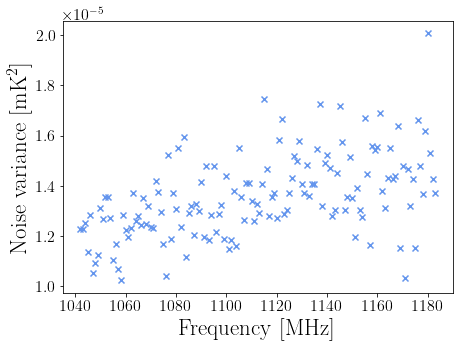

In [4]:
plt.figure(figsize=(7,5))
plt.scatter(freqs, noise_var, c='cornflowerblue', marker='x')
plt.ylabel('Noise variance [mK$^2$]', fontsize=23)
plt.xlabel('Frequency [MHz]', fontsize=23)

As you can see, our noise variance changes with frequency, and therefore it is heteroscedastic. 

See also this notebook from `GPy`, which we base some of this notebook off of, for more information:
https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb

## `noise_data` 

#### `noise_data = None` 
If we assume the noise data is `None`, we are simply saying we don't know what the noise is beforehand, and so GPR will try to find the best fitting variance for the noise given our data. If `heteroscedastic = False`, it will try to find a single best fitting noise variance ($\sigma^2_n$), but if `heteroscedastic = True` it will try to fit a best fitting noise variance for each different frequency slice ($\sigma^2_{n,i}$).

#### `noise_data = noise_data`
If you know the noise of your data (`noise_data`), or have a good estimate for it, you can simply input here your noise data cube, and GPR will do the rest of you (i.e. if `heteroscedastic = False`, GPR will calculate the variance of your noise data and set the constant noise variance to that, or if `heteroscedastic = True`, GPR will calculate the variance of the noise data at each frequency slice and set the variance at each frequency to that.

For example, if `heteroscedastic = False`, GPR will calculate your variance as follows:

In [5]:
noise_var_constant = noise_data.var()
print('Constant noise variance: ', noise_var_constant)

Constant noise variance:  1.3587374315628525e-05


Or if `heteroscedastic = True`, GPR will do:

In [6]:
noise_var_changing = obs.LoSpixels(noise_data).var(axis=1)
print('Noise variance at first frequency slice: ', noise_var_changing[0])
print('Noise variance at second frequency slice: ', noise_var_changing[1])

Noise variance at first frequency slice:  1.2287050436099756e-05
Noise variance at second frequency slice:  1.2269944318871936e-05


## `zero_noise`

#### `zero_noise = True`
This is only an option in the non-heteroscedastic case. What this means is that GPR will assume you have zero noise throughout. This is useful if you are trying to use a kernel function (such as Exponential) to describe your noise, instead of the usual way GPR treats the noise. It is also useful if you have no noise. If you want this option, you have to also set `heteroscedastic = False` and `noise_data = None`

#### `zero_noise = False`
This just assumes you do have noise in your data, and you can tweak the `noise_data` and `heteroscedastic` parameters according to your data.